# LA Restaurant Health Inspection



In [171]:
import pandas as pd
import re
from datetime import datetime
from dateutil.parser import parse
import missingno as msno
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
inspect_df = pd.read_csv('restaurant-and-market-health-inspections.csv')

In [3]:
violate_df = pd.read_csv('restaurant-and-market-health-violations.csv')

In [4]:
inspect_df.dtypes

serial_number          object
activity_date          object
facility_name          object
score                   int64
grade                  object
service_code            int64
service_description    object
employee_id            object
facility_address       object
facility_city          object
facility_id            object
facility_state         object
facility_zip           object
owner_id               object
owner_name             object
pe_description         object
program_element_pe      int64
program_name           object
program_status         object
record_id              object
dtype: object

In [71]:
def dateobj(str):
    return datetime.strptime(str, '%Y-%m-%dT%H:%M:%S')

In [72]:
inspect_df['activity_date'] = inspect_df['activity_date'].apply(dateobj)
violate_df['activity_date'] = violate_df['activity_date'].apply(dateobj)

In [75]:
inspect_df.head()

,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,...,owner_id,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,est_type,seats,risk
0,DAJ00E07B,2017-12-29,HABITAT COFFEE SHOP,95,A,1,ROUTINE INSPECTION,EE0000923,3708 N EAGLE ROCK BLVD,LOS ANGELES,...,OW0178123,GLASSELL COFFEE SHOP LLC,RESTAURANT (0-30) SEATS MODERATE RISK,1631,HABITAT COFFEE SHOP,ACTIVE,PR0160774,RESTAURANT,0-30,MODERATE RISK
1,DAQOKRFZB,2017-12-29,REILLY'S,92,A,1,ROUTINE INSPECTION,EE0000633,100 WORLD WAY # 120,LOS ANGELES,...,OW0208441,"AREAS SKYVIEW LAX JV, LLC",RESTAURANT (0-30) SEATS MODERATE RISK,1631,REILLY'S,ACTIVE,PR0193026,RESTAURANT,0-30,MODERATE RISK
2,DASJI4LUR,2017-12-29,STREET CHURROS,93,A,1,ROUTINE INSPECTION,EE0000835,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,...,OW0228670,"STREETCHURROS, INC",RESTAURANT (0-30) SEATS LOW RISK,1630,STREET CHURROS,ACTIVE,PR0179282,RESTAURANT,0-30,LOW RISK
3,DAWVA0CY3,2017-12-29,RIO GENTLEMANS CLUB,93,A,1,ROUTINE INSPECTION,EE0000958,13124 S FIGUEROA ST,LOS ANGELES,...,OW0011830,FIGUEROA GROUP INC,RESTAURANT (61-150) SEATS LOW RISK,1636,RIO GENTLEMANS CLUB,ACTIVE,PR0044776,RESTAURANT,61-150,LOW RISK
4,DAKFCHD0L,2017-12-29,LE PAIN QUOTIDIEN,93,A,1,ROUTINE INSPECTION,EE0000629,13050 SAN VICENTE BLVD STE 114,LOS ANGELES,...,OW0028928,PQ SAN VICENTE INC.,RESTAURANT (61-150) SEATS HIGH RISK,1638,LE PAIN QUOTIDIEN,ACTIVE,PR0017456,RESTAURANT,61-150,HIGH RISK


In [6]:
inspect_df.shape

(58872, 20)

In [47]:
violate_df.head()

,serial_number,activity_date,facility_name,violation_code,violation_description,violation_status,points,grade,facility_address,facility_city,...,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,score,service_code,service_description,row_id
0,DA08R0TCU,2018-03-30T00:00:00,KRUANG TEDD,F030,# 30. Food properly stored; food storage conta...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF030
1,DA08R0TCU,2018-03-30T00:00:00,KRUANG TEDD,F027,# 27. Food separated and protected,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF027
2,DA08R0TCU,2018-03-30T00:00:00,KRUANG TEDD,F035,# 35. Equipment/Utensils - approved; installed...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF035
3,DA08R0TCU,2018-03-30T00:00:00,KRUANG TEDD,F033,# 33. Nonfood-contact surfaces clean and in go...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF033
4,DA08R0TCU,2018-03-30T00:00:00,KRUANG TEDD,F029,"# 29. Toxic substances properly identified, st...",OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF029


In [8]:
violate_df.shape

(272801, 25)

In [9]:
inspect_places = inspect_df['facility_name'].unique()

In [10]:
violate_places = violate_df['facility_name'].unique()

In [11]:
inspect_df['activity_date'].min()

'2015-07-01T00:00:00'

In [12]:
inspect_df['activity_date'].max()

'2018-03-30T00:00:00'

In [13]:
violate_df['activity_date'].min()

'2015-10-01T00:00:00'

In [14]:
violate_df['activity_date'].max()

'2018-03-30T00:00:00'

In [15]:
len(set(inspect_places) - set(violate_places))

301

In [16]:
len(inspect_places) - len(violate_places)


299

In [61]:
violate_df['violation_status'].value_counts()

OUT OF COMPLIANCE       272799
HOUSING NON-CRITICAL         1
VIOLATION                    1
Name: violation_status, dtype: int64

## Violation outliers

A look at the violation codes yield codes that mostly begin with a 'F'. There seem to be a few starting with 'W' that only appear once or twice. When matched with the violation description, they were the only descriptions that did not have a violation number in front of them. Furthermore, some didn't even result in point deductions. As they only make up 17 entries out of the 272,801 violations, we can safely drop them.

In [76]:
violate_df['violation_code'].value_counts().nsmallest(20)

W019     1
W027     1
W051     1
W052     1
W032     1
W034     1
W021     1
W005     1
W004     1
W044     1
W028     1
H102     1
F056     2
W023     3
F002     6
F017    10
F012    10
F003    11
F051    12
F010    14
Name: violation_code, dtype: int64

In [64]:
violate_df[violate_df['violation_code'].isin(violate_df['violation_code'].value_counts().nsmallest(14).index)]

,serial_number,activity_date,facility_name,violation_code,violation_description,violation_status,points,grade,facility_address,facility_city,...,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,score,service_code,service_description,row_id
18900,DAZTR8FK3,2018-01-23T00:00:00,SUKARNE,W019,Plumbing approved and maintained in good repair.,OUT OF COMPLIANCE,0,A,1500 E OLYMPIC BLVD # 1-37,LOS ANGELES,...,VIZ CATTLE CORPORATION,"FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK",1611,SUKARNE,ACTIVE,PR0189140,100,1,ROUTINE INSPECTION,DAZTR8FK3W019
18901,DAZTR8FK3,2018-01-23T00:00:00,SUKARNE,W044,Garbage / Rubbish receptacles maintained clean...,OUT OF COMPLIANCE,0,A,1500 E OLYMPIC BLVD # 1-37,LOS ANGELES,...,VIZ CATTLE CORPORATION,"FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK",1611,SUKARNE,ACTIVE,PR0189140,100,1,ROUTINE INSPECTION,DAZTR8FK3W044
18902,DAZTR8FK3,2018-01-23T00:00:00,SUKARNE,W023,Floor maintained clean,OUT OF COMPLIANCE,0,A,1500 E OLYMPIC BLVD # 1-37,LOS ANGELES,...,VIZ CATTLE CORPORATION,"FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK",1611,SUKARNE,ACTIVE,PR0189140,100,1,ROUTINE INSPECTION,DAZTR8FK3W023
23139,DAZRJ0DAU,2018-01-08T00:00:00,PHILLY'S PIZZA & GRILL #1,F056,# 10. Proper cooking time & temperatures,OUT OF COMPLIANCE,4,A,8500 W OLYMPIC BLVD STE D,LOS ANGELES,...,"HOVANISIAN, PETROS",RESTAURANT (0-30) SEATS HIGH RISK,1632,PHILLY'S PIZZA & GRILL #1,ACTIVE,PR0045093,92,1,ROUTINE INSPECTION,DAZRJ0DAUF056
31175,DABOMTVP9,2017-11-30T00:00:00,SAKURA RESTAURANT WAREHOUSE,W032,Toilet room floor / walls / ceiling in good re...,OUT OF COMPLIANCE,0,A,4543 S CENTINELA AVE,LOS ANGELES,...,"TOYA, JANIS",RESTAURANT (0-30) SEATS LOW RISK,1630,SAKURA RESTAURANT WAREHOUSE,ACTIVE,PR0005284,100,1,ROUTINE INSPECTION,DABOMTVP9W032
59346,DA9K7IRLN,2017-08-23T00:00:00,PLAZA FISH MARKET,F056,# 10. Proper cooking time & temperatures,OUT OF COMPLIANCE,4,A,4042 S WESTERN AVE,LOS ANGELES,...,"JUN, DONG IM",RESTAURANT (0-30) SEATS HIGH RISK,1632,PLAZA FISH MARKET,ACTIVE,PR0029586,95,1,ROUTINE INSPECTION,DA9K7IRLNF056
67598,DAFLYALQR,2017-07-25T00:00:00,SIMPLY SALAD,H102,Permit Available,HOUSING NON-CRITICAL,0,A,11726 SAN VICENTE BLVD # 150,LOS ANGELES,...,"BT LEWIS ENTERPRISES, LLC",RESTAURANT (31-60) SEATS HIGH RISK,1635,SIMPLY SALAD,ACTIVE,PR0190265,100,1,ROUTINE INSPECTION,DAFLYALQRH102
71003,DAJQZQAYB,2017-07-13T00:00:00,SUKARNE,W021,Wall(s) maintained in good repair,OUT OF COMPLIANCE,0,A,1500 E OLYMPIC BLVD # 1-37,LOS ANGELES,...,VIZ CATTLE CORPORATION,"FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK",1611,SUKARNE,ACTIVE,PR0189140,100,1,ROUTINE INSPECTION,DAJQZQAYBW021
71004,DAJQZQAYB,2017-07-13T00:00:00,SUKARNE,W023,Floor maintained clean,OUT OF COMPLIANCE,0,A,1500 E OLYMPIC BLVD # 1-37,LOS ANGELES,...,VIZ CATTLE CORPORATION,"FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK",1611,SUKARNE,ACTIVE,PR0189140,100,1,ROUTINE INSPECTION,DAJQZQAYBW023
103863,DA2TVDIDX,2017-03-22T00:00:00,SUKARNE,W005,Food elevated,OUT OF COMPLIANCE,0,A,1500 E OLYMPIC BLVD # 1-37,LOS ANGELES,...,VIZ CATTLE CORPORATION,"FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK",1611,SUKARNE,ACTIVE,PR0189140,100,1,ROUTINE INSPECTION,DA2TVDIDXW005


In [51]:
violate_df['violation_description'].value_counts()

# 44. Floors, walls and ceilings: properly built, maintained in good repair and clean      30289
# 33. Nonfood-contact surfaces clean and in good repair                                    28426
# 35. Equipment/Utensils - approved; installed; clean; good repair, capacity               23596
# 36. Equipment, utensils and linens: storage and use                                      15214
# 40. Plumbing: Plumbing in good repair, proper backflow devices                           14865
# 43. Premises; personal/cleaning items; vermin-proofing                                   14711
# 37. Adequate ventilation and lighting; designated areas, use                             12852
# 39. Wiping cloths: properly used and stored                                              12138
# 30. Food properly stored; food storage containers identified                             11368
# 06. Adequate handwashing facilities supplied & accessible                                10874
# 14. Food contact surfaces: c

In [77]:
violate_df = violate_df[~violate_df['violation_code'].isin(violate_df['violation_code'].value_counts().nsmallest(14).index)]
violate_df.shape

(272784, 25)

In [19]:
len(violate_df['violation_description'].unique())

66

In [20]:
len(violate_df['violation_code'].unique())

70

## Creating new features based on establishment description

When looking at the column 'pe_description', it seems to describe 3 different things: what type of establishment it is, how many people it can host, and the risk level.

To better represent the data, we write three helper functions with regex and string split to create new feature variables.

In [21]:
inspect_df['pe_description'].unique()

array(['RESTAURANT (0-30) SEATS MODERATE RISK',
       'RESTAURANT (0-30) SEATS LOW RISK',
       'RESTAURANT (61-150) SEATS LOW RISK',
       'RESTAURANT (61-150) SEATS HIGH RISK',
       'FOOD MKT RETAIL (25-1,999 SF) LOW RISK',
       'RESTAURANT (0-30) SEATS HIGH RISK',
       'FOOD MKT RETAIL (2,000+ SF) LOW RISK',
       'RESTAURANT (31-60) SEATS HIGH RISK',
       'FOOD MKT RETAIL (25-1,999 SF) MODERATE RISK',
       'RESTAURANT (151 + ) SEATS MODERATE RISK',
       'RESTAURANT (61-150) SEATS MODERATE RISK',
       'RESTAURANT (151 + ) SEATS HIGH RISK',
       'FOOD MKT RETAIL (25-1,999 SF) HIGH RISK',
       'RESTAURANT (31-60) SEATS MODERATE RISK',
       'FOOD MKT RETAIL (2,000+ SF) HIGH RISK',
       'FOOD MKT RETAIL (2,000+ SF) MODERATE RISK',
       'RESTAURANT (31-60) SEATS LOW RISK',
       'RESTAURANT (151 + ) SEATS LOW RISK'], dtype=object)

In [22]:
teststr = 'FOOD MKT RETAIL (25-1,999 SF) LOW RISK'

### Quick and dirty regex

A quick description of the two regex statements used here:

For extracting the type of establishment, we want to get everything before the first opening parentheses. The regex was thus in the form .+(?= \()
<br>.+ => This matches, returns any character, and keeps going. The use of '+' means it has to match at least once.
<br>(?= \() => This is a lookahead which indicates that the string ends with ' (' and that the open parentheses will not be returned. 

For extracting the size of the establishment, I used the regex (?<=\().+(?=\))
<br>(?<=\() => This is a lookbehind which indicates that the string starts with an open parentheses which will not be returned.
<br>.+ => Like above, returns any character and continues.
<br>(?=\)) => Like above, a lookahead that indicates the string ends with a close parentheses which will not be returned.

In [88]:
def find_est(str):
    est = re.compile('.+(?= \()')
    return est.search(str).group(0)
def find_size(str):
    size = re.compile('(?<=\().+(?=\))')
    return size.search(str).group(0)
def find_risk(str):
    return (' ').join(str.split(' ')[-2:])

In [89]:
print(find_est(teststr))
print(find_size(teststr))
print(find_risk(teststr))

FOOD MKT RETAIL
25-1,999 SF
LOW RISK


In [90]:
inspect_df['owner_name'].value_counts().nlargest(10)

RALPHS GROCERY COMPANY                          557
LEVY PREMIUM FOOD SERVICE LP                    468
LEVY PREMIUM FOODSERVICE LIMITED PARTNERSHIP    323
STARBUCKS COFFEE CORPORATION                    273
LEGENDS HOSPITALITY, LLC.                       234
THE VONS COMPANIES INC.                         234
FOOD 4 LESS, INC.                               232
HOST INTERNATIONAL INC                          211
WHOLE FOODS MARKET, INC.                        198
SOUTHERN CALIFORNIA PIZZA CO LLC                167
Name: owner_name, dtype: int64

In [91]:
inspect_df['est_type'] = inspect_df['pe_description'].apply(find_est)
inspect_df['seats'] = inspect_df['pe_description'].apply(find_size)
inspect_df['risk'] = inspect_df['pe_description'].apply(find_risk)
inspect_df.head()

,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,...,owner_id,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,est_type,seats,risk
0,DAJ00E07B,2017-12-29,HABITAT COFFEE SHOP,95,A,1,ROUTINE INSPECTION,EE0000923,3708 N EAGLE ROCK BLVD,LOS ANGELES,...,OW0178123,GLASSELL COFFEE SHOP LLC,RESTAURANT (0-30) SEATS MODERATE RISK,1631,HABITAT COFFEE SHOP,ACTIVE,PR0160774,RESTAURANT,0-30,MODERATE RISK
1,DAQOKRFZB,2017-12-29,REILLY'S,92,A,1,ROUTINE INSPECTION,EE0000633,100 WORLD WAY # 120,LOS ANGELES,...,OW0208441,"AREAS SKYVIEW LAX JV, LLC",RESTAURANT (0-30) SEATS MODERATE RISK,1631,REILLY'S,ACTIVE,PR0193026,RESTAURANT,0-30,MODERATE RISK
2,DASJI4LUR,2017-12-29,STREET CHURROS,93,A,1,ROUTINE INSPECTION,EE0000835,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,...,OW0228670,"STREETCHURROS, INC",RESTAURANT (0-30) SEATS LOW RISK,1630,STREET CHURROS,ACTIVE,PR0179282,RESTAURANT,0-30,LOW RISK
3,DAWVA0CY3,2017-12-29,RIO GENTLEMANS CLUB,93,A,1,ROUTINE INSPECTION,EE0000958,13124 S FIGUEROA ST,LOS ANGELES,...,OW0011830,FIGUEROA GROUP INC,RESTAURANT (61-150) SEATS LOW RISK,1636,RIO GENTLEMANS CLUB,ACTIVE,PR0044776,RESTAURANT,61-150,LOW RISK
4,DAKFCHD0L,2017-12-29,LE PAIN QUOTIDIEN,93,A,1,ROUTINE INSPECTION,EE0000629,13050 SAN VICENTE BLVD STE 114,LOS ANGELES,...,OW0028928,PQ SAN VICENTE INC.,RESTAURANT (61-150) SEATS HIGH RISK,1638,LE PAIN QUOTIDIEN,ACTIVE,PR0017456,RESTAURANT,61-150,HIGH RISK


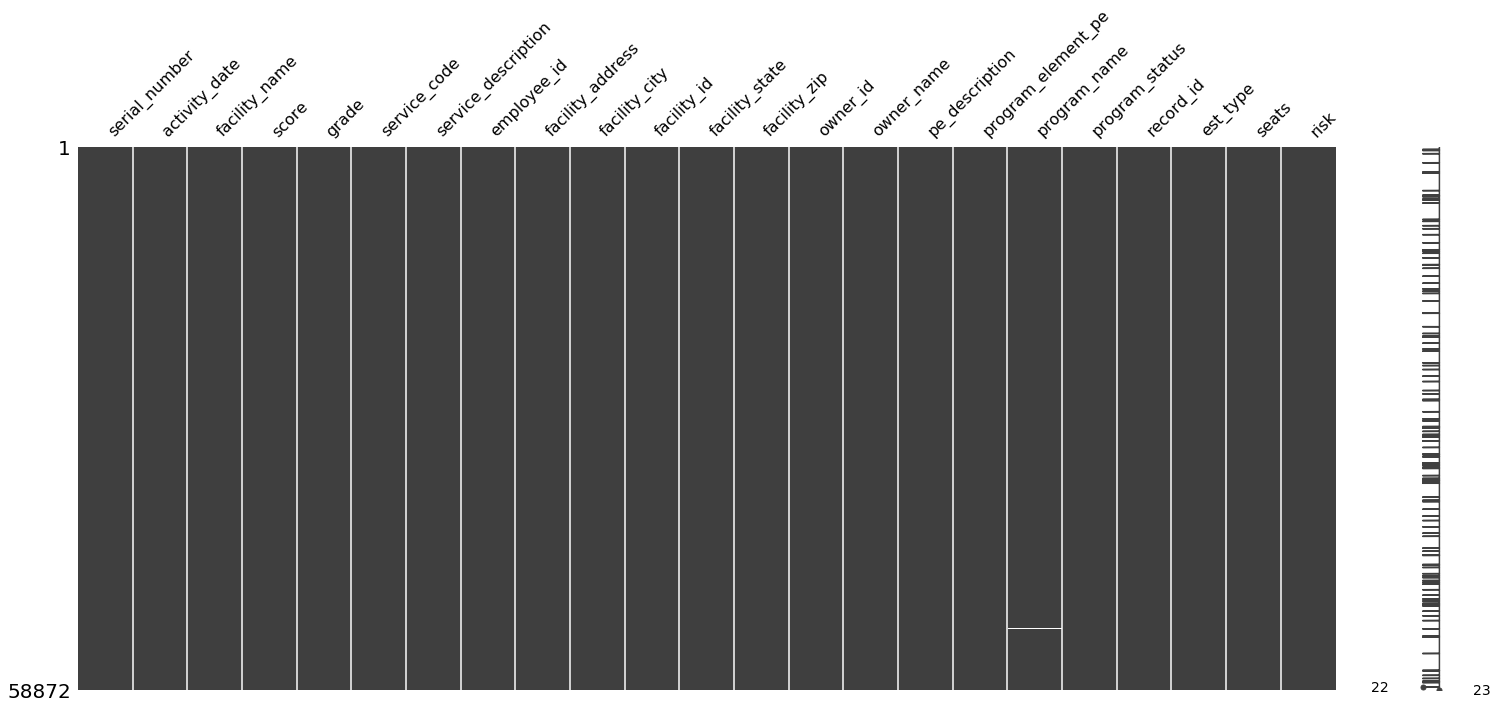

In [86]:
%matplotlib inline
msno.matrix(inspect_df)

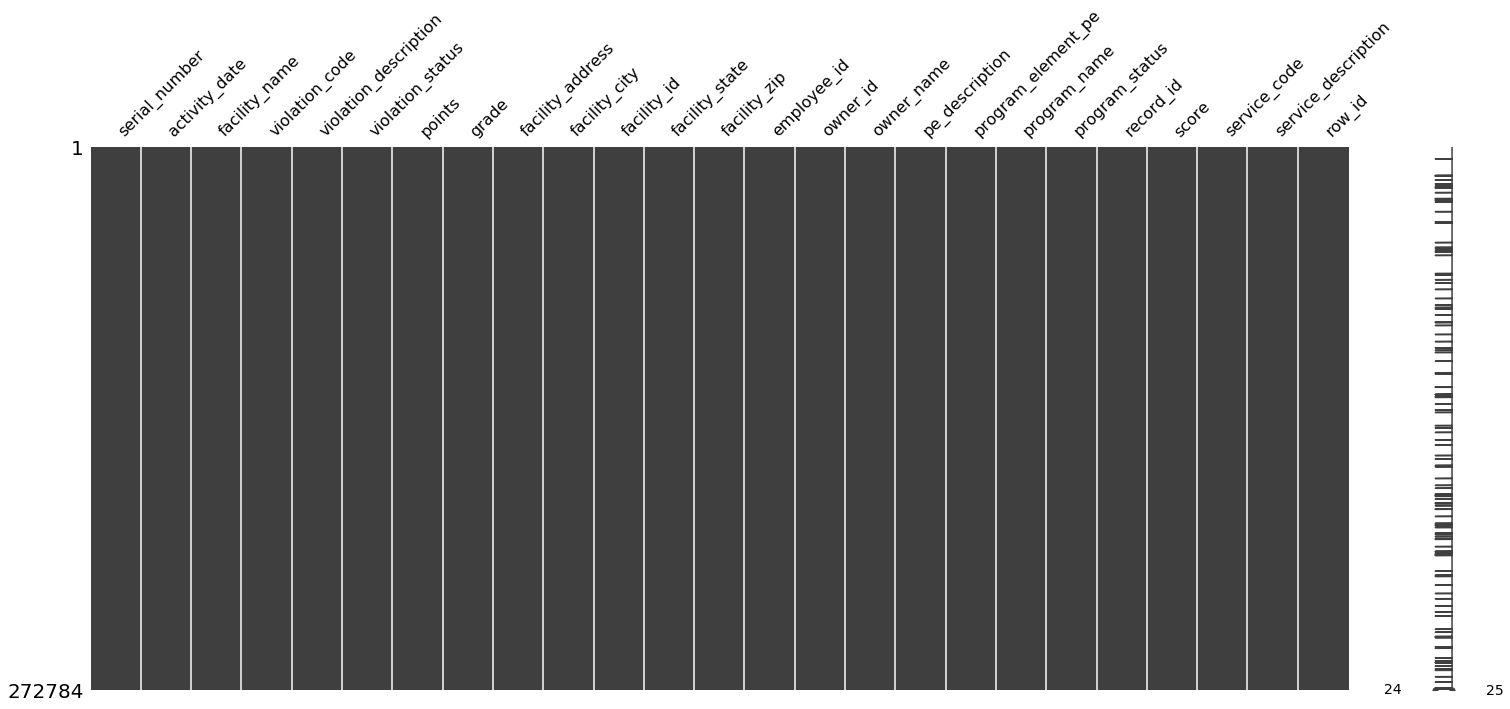

In [87]:
%matplotlib inline
msno.matrix(violate_df)

In [93]:
violate_df.head()

,serial_number,activity_date,facility_name,violation_code,violation_description,violation_status,points,grade,facility_address,facility_city,...,owner_name,pe_description,program_element_pe,program_name,program_status,record_id,score,service_code,service_description,row_id
0,DA08R0TCU,2018-03-30,KRUANG TEDD,F030,# 30. Food properly stored; food storage conta...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF030
1,DA08R0TCU,2018-03-30,KRUANG TEDD,F027,# 27. Food separated and protected,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF027
2,DA08R0TCU,2018-03-30,KRUANG TEDD,F035,# 35. Equipment/Utensils - approved; installed...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF035
3,DA08R0TCU,2018-03-30,KRUANG TEDD,F033,# 33. Nonfood-contact surfaces clean and in go...,OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF033
4,DA08R0TCU,2018-03-30,KRUANG TEDD,F029,"# 29. Toxic substances properly identified, st...",OUT OF COMPLIANCE,1,A,5151 HOLLYWOOD BLVD,LOS ANGELES,...,5151 HOLLYWOOD LLC,RESTAURANT (31-60) SEATS HIGH RISK,1635,KRUANG TEDD,ACTIVE,PR0031205,92,1,ROUTINE INSPECTION,DA08R0TCUF029


## Creating dataframe of all violation counts

Individual violations do not seem to tell us much about a particular location. Let's create a new dataframe from the violation dataframe that represents all the different violations and the total number of each violation each facility has.

We begin this by grouping the violation dataframe by the facility id and the violation code. We then aggregate by the count to find the total times each facility has violated a particular rule. 

In [148]:
vio_grouped = violate_df.groupby(['facility_id','violation_code'])
vio_counts = vio_grouped.agg({
    'violation_code': 'count'
})
vio_counts.head()

violation_code
facility_id violation_code                
FA0000968   F006                         1
            F029                         2
            F033                         3
            F035                         1
            F036                         3

We take this new dataframe and unstack it. We then transpose the resultant dataframe so that the violation codes are now the columns. We then reset the index so that a new facility_id column is created. Now we can merge the inspection dataframe with this dataframe so that each facility has a set of columns for the counts of every violation.

In [149]:
vio_matrix = vio_counts['violation_code'].unstack(0).T

In [150]:
vio_matrix.index

Index(['FA0000968', 'FA0000999', 'FA0001155', 'FA0001320', 'FA0001404',
       'FA0001531', 'FA0001538', 'FA0001579', 'FA0001714', 'FA0001949',
       ...
       'FA0257917', 'FA0257920', 'FA0257957', 'FA0257976', 'FA0257995',
       'FA0258015', 'FA0258130', 'FA0258138', 'FA0258144', 'FA0258145'],
      dtype='object', name='facility_id', length=12727)

In [151]:
vio_matrix.columns

Index(['F001', 'F002', 'F003', 'F004', 'F005', 'F006', 'F007', 'F008', 'F009',
       'F010', 'F011', 'F012', 'F013', 'F014', 'F015', 'F016', 'F017', 'F018',
       'F019', 'F021', 'F022', 'F023', 'F024', 'F025', 'F026', 'F027', 'F028',
       'F029', 'F030', 'F031', 'F032', 'F033', 'F034', 'F035', 'F036', 'F037',
       'F038', 'F039', 'F040', 'F041', 'F042', 'F043', 'F044', 'F045', 'F046',
       'F047', 'F048', 'F049', 'F050', 'F051', 'F052', 'F053', 'F054', 'F055',
       'F057', 'F058'],
      dtype='object', name='violation_code')

In [152]:
vio_matrix.fillna(0, inplace=True)

In [153]:
vio_matrix

violation_code,F001,F002,F003,F004,F005,F006,F007,F008,F009,F010,...,F048,F049,F050,F051,F052,F053,F054,F055,F057,F058
facility_id,,,,,,,,,,,,,,,,,,,,,
FA0000968,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FA0000999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FA0001155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FA0001320,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FA0001404,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
FA0001531,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
FA0001538,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FA0001579,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FA0001714,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,2.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [154]:
# vio_matrix['facility_id'] = vio_matrix.index
vio_matrix.reset_index(inplace=True)
vio_matrix

violation_code,facility_id,F001,F002,F003,F004,F005,F006,F007,F008,F009,...,F048,F049,F050,F051,F052,F053,F054,F055,F057,F058
0,FA0000968,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,FA0000999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,FA0001155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,FA0001320,0.0,0.0,0.0,0.0,0.0,1.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,FA0001404,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5,FA0001531,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,FA0001538,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,FA0001579,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,FA0001714,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,2.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
9,FA0001949,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [157]:
inspect_vio_df = pd.merge(inspect_df, vio_matrix, on='facility_id', how='left')
inspect_vio_df.head()

,serial_number,activity_date,facility_name,score,grade,service_code,service_description,employee_id,facility_address,facility_city,...,F048,F049,F050,F051,F052,F053,F054,F055,F057,F058
0,DAJ00E07B,2017-12-29,HABITAT COFFEE SHOP,95,A,1,ROUTINE INSPECTION,EE0000923,3708 N EAGLE ROCK BLVD,LOS ANGELES,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DAQOKRFZB,2017-12-29,REILLY'S,92,A,1,ROUTINE INSPECTION,EE0000633,100 WORLD WAY # 120,LOS ANGELES,...,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,DASJI4LUR,2017-12-29,STREET CHURROS,93,A,1,ROUTINE INSPECTION,EE0000835,6801 HOLLYWOOD BLVD # 253,LOS ANGELES,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,DAWVA0CY3,2017-12-29,RIO GENTLEMANS CLUB,93,A,1,ROUTINE INSPECTION,EE0000958,13124 S FIGUEROA ST,LOS ANGELES,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,DAKFCHD0L,2017-12-29,LE PAIN QUOTIDIEN,93,A,1,ROUTINE INSPECTION,EE0000629,13050 SAN VICENTE BLVD STE 114,LOS ANGELES,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


A quick look at the missing values reveals that there are a couple of facilities with NA values across all the violation codes. Lets assume that these are facilities that have never broken a rule and fillna(0) to represent zero violations.

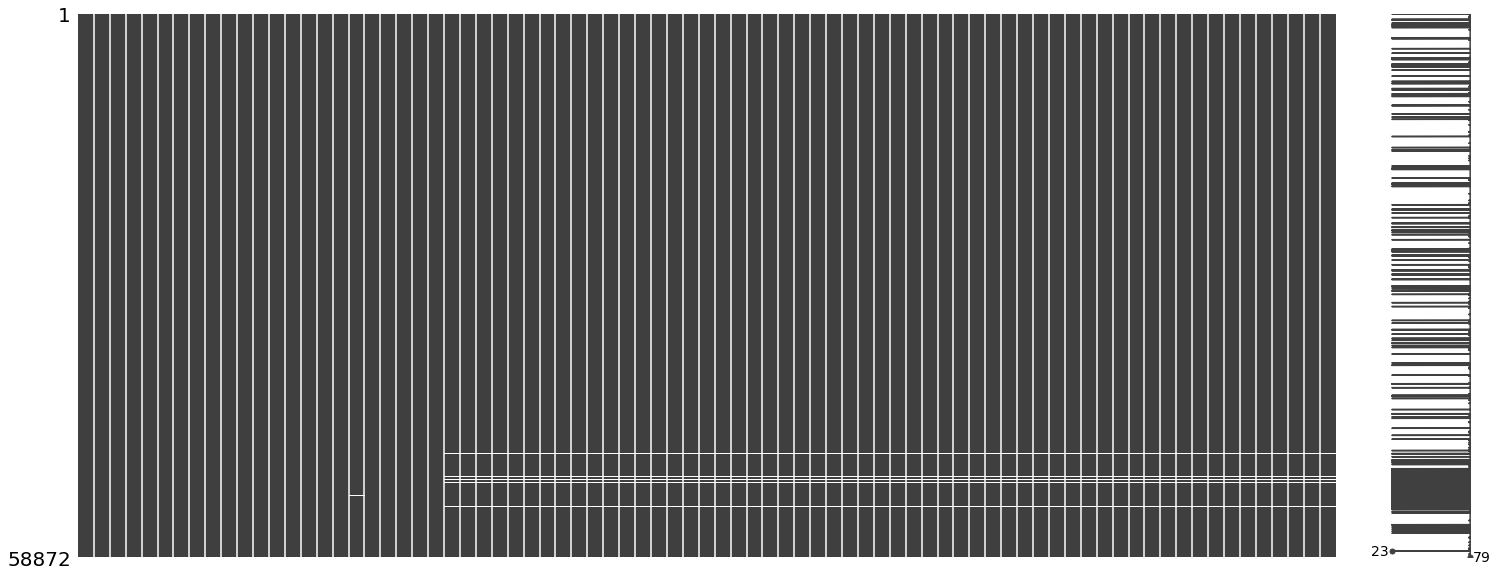

In [163]:
%matplotlib inline
msno.matrix(inspect_vio_df)

In [168]:
inspect_vio_df.fillna(0, inplace = True)

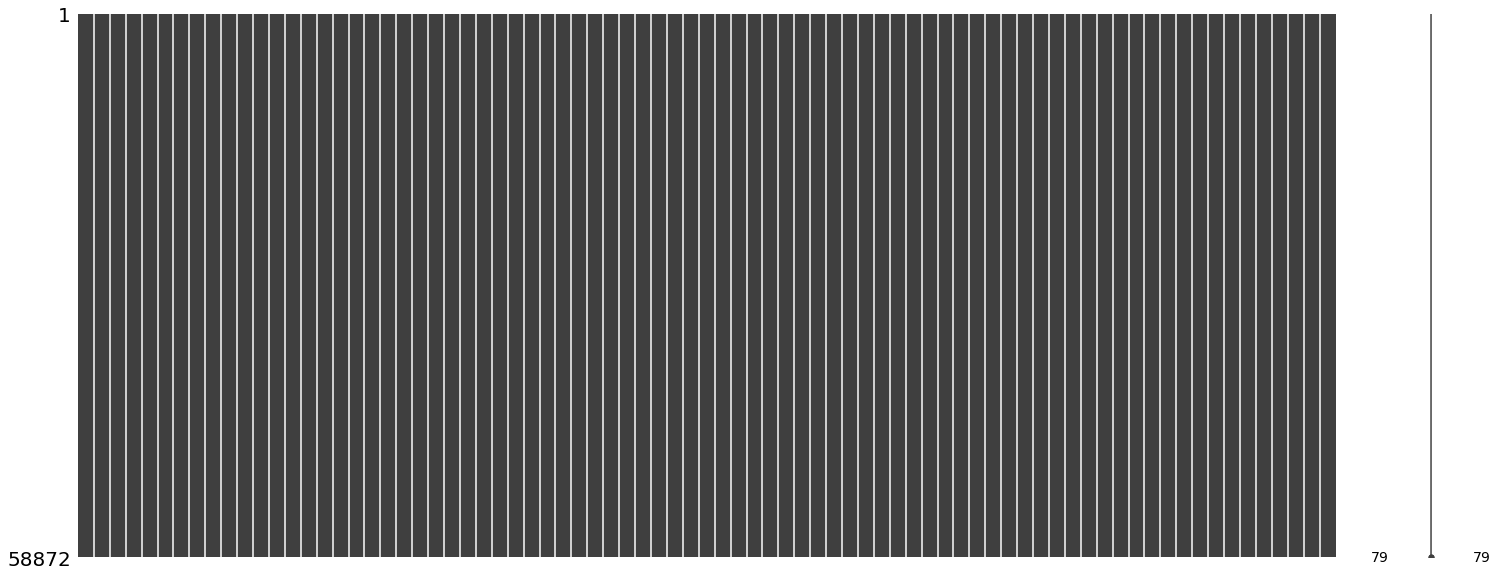

In [169]:
%matplotlib inline
msno.matrix(inspect_vio_df)

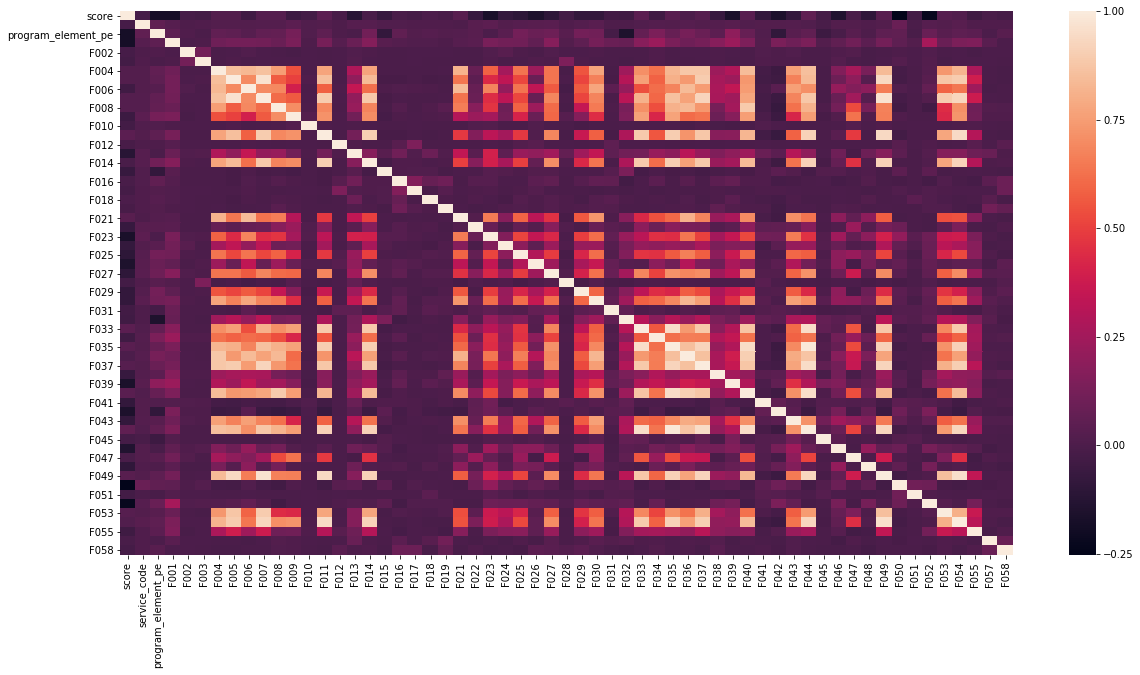

In [174]:
plt.figure(figsize=(20,10))
sb.heatmap(inspect_vio_df.corr())

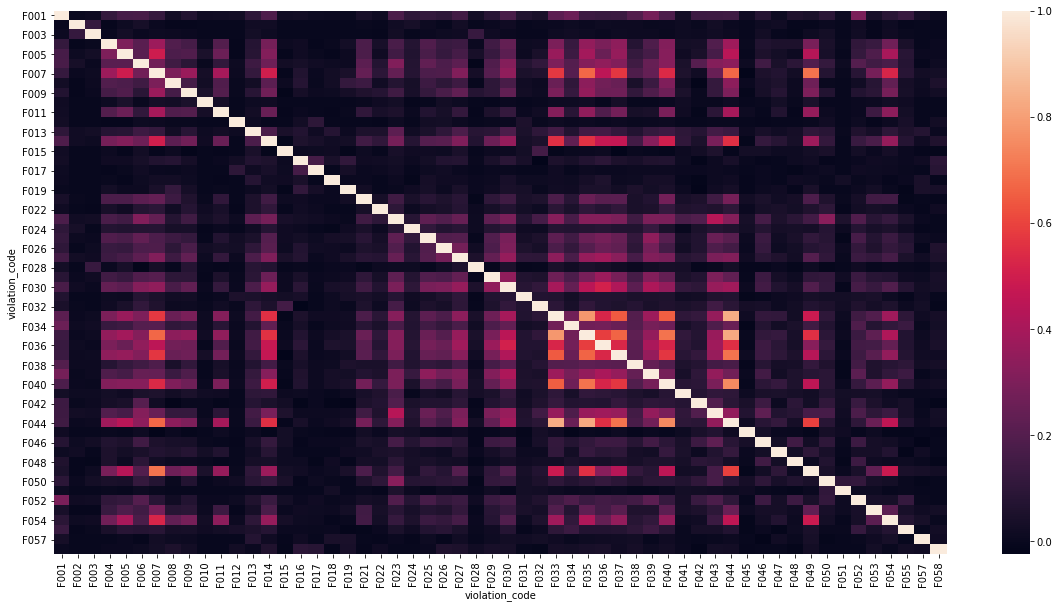

In [177]:
plt.figure(figsize=(20,10))
sb.heatmap(vio_matrix.corr())

In [179]:
inspect_vio_df.columns

Index(['serial_number', 'activity_date', 'facility_name', 'score', 'grade',
       'service_code', 'service_description', 'employee_id',
       'facility_address', 'facility_city', 'facility_id', 'facility_state',
       'facility_zip', 'owner_id', 'owner_name', 'pe_description',
       'program_element_pe', 'program_name', 'program_status', 'record_id',
       'est_type', 'seats', 'risk', 'F001', 'F002', 'F003', 'F004', 'F005',
       'F006', 'F007', 'F008', 'F009', 'F010', 'F011', 'F012', 'F013', 'F014',
       'F015', 'F016', 'F017', 'F018', 'F019', 'F021', 'F022', 'F023', 'F024',
       'F025', 'F026', 'F027', 'F028', 'F029', 'F030', 'F031', 'F032', 'F033',
       'F034', 'F035', 'F036', 'F037', 'F038', 'F039', 'F040', 'F041', 'F042',
       'F043', 'F044', 'F045', 'F046', 'F047', 'F048', 'F049', 'F050', 'F051',
       'F052', 'F053', 'F054', 'F055', 'F057', 'F058'],
      dtype='object')

In [140]:
violate_df['violation_code'].unique()

array(['F030', 'F027', 'F035', 'F033', 'F029', 'F044', 'F006', 'F039',
       'F037', 'F032', 'F034', 'F014', 'F043', 'F042', 'F009', 'F007',
       'F036', 'F038', 'F048', 'F040', 'F049', 'F046', 'F023', 'F055',
       'F013', 'F025', 'F053', 'F041', 'F052', 'F054', 'F024', 'F026',
       'F028', 'F050', 'F008', 'F016', 'F058', 'F005', 'F045', 'F004',
       'F047', 'F011', 'F022', 'F051', 'F015', 'F031', 'F057', 'F021',
       'F002', 'F012', 'F003', 'F017', 'F001', 'F019', 'F018', 'F010'], dtype=object)

In [141]:
violate_df['violation_description'].unique()

array(['# 30. Food properly stored; food storage containers identified',
       '# 27. Food separated and protected',
       '# 35. Equipment/Utensils - approved; installed; clean; good repair, capacity',
       '# 33. Nonfood-contact surfaces clean and in good repair',
       '# 29. Toxic substances properly identified, stored, used',
       '# 44. Floors, walls and ceilings: properly built, maintained in good repair and clean',
       '# 06. Adequate handwashing facilities supplied & accessible',
       '# 39. Wiping cloths: properly used and stored',
       '# 37. Adequate ventilation and lighting; designated areas, use',
       '# 32. Food properly labeled & honestly presented',
       '# 34. Warewashing facilities: Adequate, maintained, properly use, test strips available',
       '# 14. Food contact surfaces: clean and sanitized',
       '# 43. Premises; personal/cleaning items; vermin-proofing',
       '# 42. Toilet facilities: properly constructed, supplied, cleaned',
       '#